# TP2: Filter Banks

By Daniel Jorge Deutsch, Kevin Kuhl and Brayam Santiago Velandia (25/09/2020)

In [84]:
import os
import struct
import sys
import time
import warnings
import wave
from copy import deepcopy
from math import ceil
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyaudio
from scipy import signal as sig
from scipy.io import wavfile
from scipy.linalg import hankel
from scipy.linalg import norm
from scipy.linalg import inv

In [85]:
class Base:

    def __init__(self, name, tdata=None, freq=None, mag=None):

        if not ((tdata is None) ^ (freq is None or mag is None)):
            raise Exception("You must provide a tdata or a freq and mag arrays")
        if not(freq is None or mag is None):
            if len(freq) != len(mag):
                raise Exception("freq and mag arrays must be of the same length")
        
        self.name = name

        # Time domain attributes
        if not(tdata is None):
            self.tdata = np.asarray(tdata)
        else:
            self.tdata = np.fft.ifft(mag)

        # Frequency domain attributes
        if not(freq is None or mag is None):
            self.freq = np.asarray(freq)
            self.mag = np.asarray(mag)
        else:
            len_fft = 4096                                                           # Length of the transformed axis of the output
            self.freq, self.mag = sig.freqz(self.tdata, worN=len_fft, whole=True)    # Obtains the frequency and magnitude
            self.freq = self.freq/(2*np.pi)                                                    # Converts the frequency to (rad/sample)/2π


    
    #------------------------------#
    #--- SAMPLES ------------------#
    #------------------------------#

    def step_split_sample(self, step):
        tdatas = [self.tdata[i::step] for i in range(step)]
        max_len = max([len(tdata) for tdata in tdatas])
        for i, tdata in enumerate(tdatas):
            if len(tdata) != max_len:
                tdatas[i] = np.append(tdata, 0)
            tdatas[i] = self.__class__(f"{self.name}{i}", tdatas[i])
        return tuple(datas) 



    #------------------------------#
    #--- PLOTS --------------------#
    #------------------------------#
    
    def data_plot(self, discrete=False, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the xaxis
        xaxis = np.abs(self.tdata) if absolute else self.tdata
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Plot of {self.name}")
        plt.stem(xaxis) if discrete else plt.plot(xaxis)
        plt.xlim(0, len(xaxis)-1)
        plt.ylabel("Amplitude")
        plt.xlabel("Index")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_data.png", dpi=300, bbox_inches="tight")
        plt.show()


    def spectrogram_plot(self, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):
        
        # Obtain the spectrogram params
        f, t, Sxx = sig.spectrogram(self.tdata, self.freq)

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Spectogram of {self.name}")
        plt.pcolormesh(t, f, 20*np.log10(Sxx), shading="auto")
        plt.ylabel("Frequency [Hz]")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_spectrogram.png", dpi=300, bbox_inches="tight")
        plt.show()


    def freqz_plot(self, whole=False, absolute=True, db=True, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Frequency
        freq = self.freq

        # Magnitude
        mag = np.abs(self.mag) if absolute else self.mag
        mag = 20*np.log10(mag) if db else mag
        mag[np.abs(mag-np.mean(mag)) > 2*np.std(mag)] = np.nan   # Remove outliers for the plot

        if not whole:
            mag = mag[:int(len(mag)/2)]
            freq = freq[:int(len(freq)/2)]
        
        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Frequency response of {self.name}")
        plt.plot(freq, mag)
        plt.xlim(freq[0], freq[-1])
        plt.ylabel("Magnitude [dB]") if db else plt.ylabel("Magnitude")
        plt.xlabel("Frequency [(rad/sample)/2π]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.axhline(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_freqz.png", dpi=300, bbox_inches="tight")
        plt.show() 

In [86]:
class Signal(Base):

    def __init__(self, name, tdata=None, freq=None, mag=None, fs=None, file=None):
        if not ((tdata is None) ^ (file == None)):
            raise Exception("You must provide a tdata or a .wav file")
        if file:
            fs, tdata = wavfile.read(file)
        self.fs = int(fs) if fs else fs
        Base.__init__(self, name, tdata)


    #------------------------------#
    #--- SHIFTING -----------------#
    #------------------------------#

    def shift(self, name, power_of_z):
        tdata = self.tdata
        tdata = np.append(tdata[power_of_z:], power_of_z*[0]) if power_of_z > 0 else np.append(abs(power_of_z)*[0], tdata[:power_of_z])
        return self.__class__(name, tdata, self.fs)


    #------------------------------#
    #--- SAMPLING -----------------#
    #------------------------------#

    def under_sample(self, name, M):
        tdatas = self.step_split_sample(M)
        return self.__class__(name=name, tdata=tdatas[0].tdata, freq=self.fs/M)


    def over_sample(self, name, L):
        tdata = np.insert(self.tdata, range(1, len(self.tdata)+1)[::L-1], 0)
        return self.__class__(name=name, tdata=tdata, freq=self.fs*L) 
    

    #------------------------------#
    #--- PLOT ---------------------#
    #------------------------------#

    def time_plot(self, absolute=False, xhighlights=[], yhighlights=[], figsize=(15, 4), save=False):

        # Obtains the time axis
        t = np.linspace(0, len(self.tdata)/self.fs, len(self.tdata))

        # Plot
        plt.figure(figsize=figsize)
        plt.title(f"Time plot of {self.name}")
        plt.plot(t, np.abs(self.tdata)) if absolute else plt.plot(t, self.tdata)            
        plt.xlim(t[0], t[-1])
        plt.ylabel("Amplitude")
        plt.xlabel("Time [s]")
        for xhighlight in xhighlights:
            plt.axvline(x=xhighlight, color="red")
        for yhighlight in yhighlights:
            plt.hlines(y=yhighlight, color="red")
        if save:
            plt.savefig(f"./outputs/figures/{self.name}_time.png", dpi=300, bbox_inches="tight")
        plt.show()
            

    #------------------------------#
    #--- LISTEN -------------------#
    #------------------------------#

    def listen(self):
        
        # Saves the .wav
        if not self.fs:
            raise Exception("the sample freq (sample/sec) must be provided")
        wavfile.write(f"./outputs/sounds/{self.name}.wav", self.fs, np.asarray(self.tdata, dtype=np.int16))

        # Uses pyaudio to play the signal
        chunk = 1024
        pa = pyaudio.PyAudio()
        audio = wave.open(f"./outputs/sounds/{self.name}.wav", "rb")
        stream = pa.open(
            format = pa.get_format_from_width(audio.getsampwidth()),
            channels = audio.getnchannels(),
            rate = audio.getframerate(),
            output = True
        )
        data = audio.readframes(chunk)
        while data:
            stream.write(data)
            data = audio.readframes(chunk)
        stream.stop_stream()
        stream.close()
        pa.terminate()

In [87]:
class Filter(Base):

    def apply(self, name, signal):
        conv = np.convolve(self.tdata, signal.tdata)
        return Signal(name, tdata=conv, fs=signal.fs)

# 1.1

On the plot shown below we can clearly see that the Chebyshev’s alternance property holds, since the filter's oscilations have the same δ.



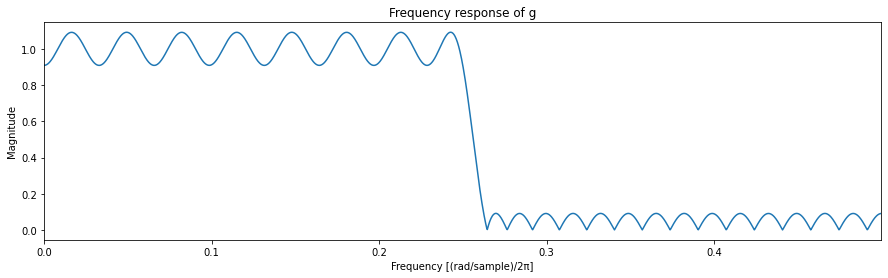


On the plot shon below we can clearly see that the half-band condition doesn't hold since one out of two coefficients of g(n) isn't zero.



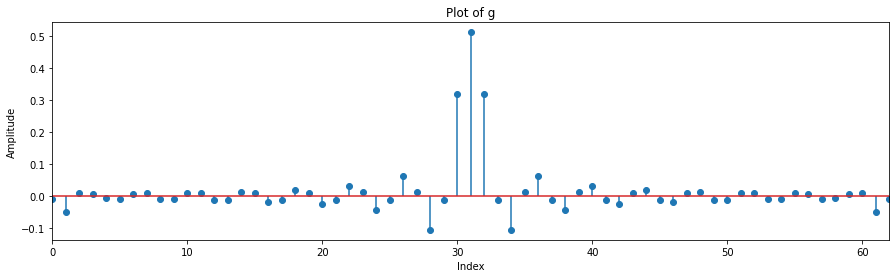

In [88]:
N = 32                  # Size of the filter v
trans_width = 1/80      # Transition width
cutoff = 1/4            # Cutoff frequency

# Obtains the Remez filter
g = Filter("g", tdata=sig.remez(2*N-1, [0, cutoff, cutoff+trans_width, 1/2], [1, 0]))

# Concludes about the Chebyshev’s alternance property
print("On the plot shown below we can clearly see that the Chebyshev’s alternance property holds, since the filter's oscilations have the same δ.\n")
g.freqz_plot(db=False)

# Concludes about the half-band condition
print("\nOn the plot shon below we can clearly see that the half-band condition doesn't hold since one out of two coefficients of g(n) isn't zero.\n")
g.data_plot(discrete=True)

# 1.2

On the plot shown below we can clearly see that the Chebyshev’s alternance property doesn't hold since the filter's oscilations don't have the same δ.



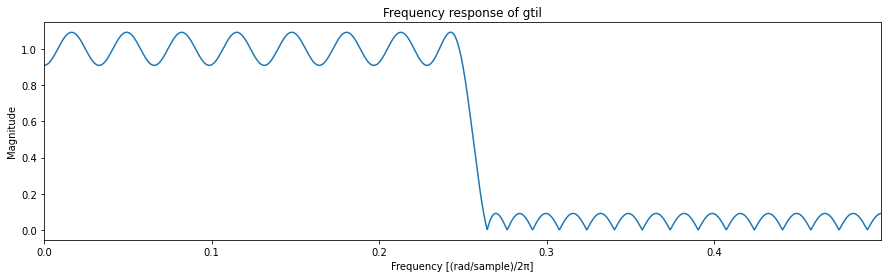

In [89]:
# Creates the filter gtil that cancels one out every two coefficients of the filter g
gtil = Filter("gtil", tdata=deepcopy(g.tdata))
for i, coef in enumerate(gtil.tdata):
    if i % 2 != 0 and i != int(len(gtil.tdata)/2):
        gtil.tdata[i] = 0

# 
# Concludes about the Chebyshev’s alternance property
print("On the plot shown below we can clearly see that the Chebyshev’s alternance property doesn't hold since the filter's oscilations don't have the same δ.\n")
gtil.freqz_plot(db=False)

# 1.3

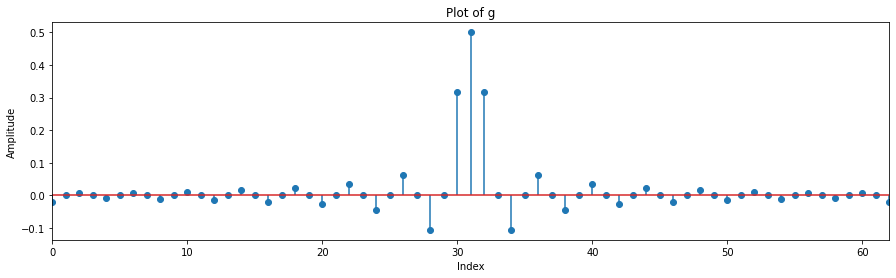

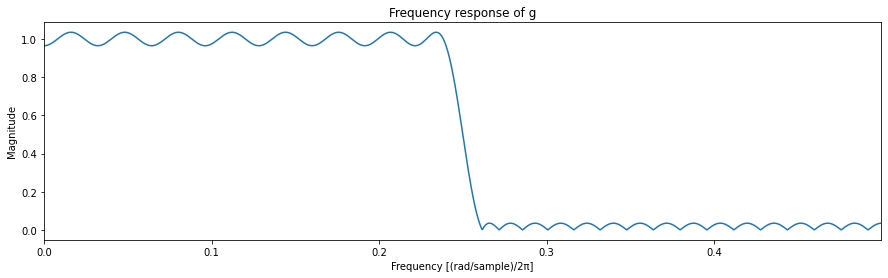

In [90]:
# Defines the Remez filter params
trans_width = 0.02   # Transition width
cutoff = 0.48        # Cutoff frequency

# Obtains the nearly all-pass type II Remez filter
v = Filter("v", tdata=sig.remez(N, [0, cutoff, cutoff+trans_width, 0.5], [1, 0]))

# Obtains the low-pass filter dirived from the filter v
c = 0.5                                                                    # Defines the constant c
δdir = Filter("δ", tdata=(N-1)*[0] + [1] + (N-1)*[0])                      # Obtains the dirac δ(n - (N-1))
v_2 = Filter("v_2", tdata=np.insert(v.tdata, range(1, len(v.tdata)), 0))   # Obtains the V(z^2) in the time domain
g = Filter("g", tdata=c*v_2.tdata + c*δdir.tdata)                          # Obtains g(n)

# Plots the obtained filter
g.data_plot(discrete=True)
g.freqz_plot(db=False)

# 1.4

By plotting GR(ν) we can clearly see that it assumes negative values in higher frequencies:



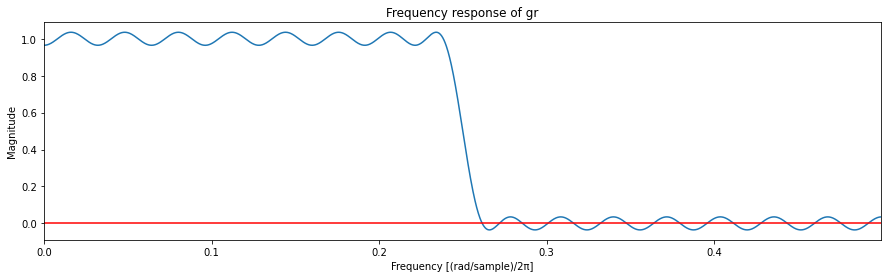


Therefore its impossible to o factorize GR(ν) in the form GR(ν) = Htil0(e2iπν)H0(e2iπν) because the product of Htil0(e2iπν) by H0(e2iπν) is always positive.


In [91]:
# Obtains the magnitude and frequency arrays of g
len_fft = 4096                                             # Sets the size of the signal gr
freq, mag = sig.freqz(g.tdata, worN=len_fft, whole=True)   # Obtains the frequency (in (rad/sample)/2π) and the magnitude arrays of G(ν)
freq = freq/(2*np.pi)                                      # Converts the frequency to rad/sample

# Obtains the filter gr by doing the inverse Fourrier transformation of Gr(ν) = |G(ν)|*exp(j2πν(N-1))
gr = Filter("gr", mag=[mag*np.exp(np.complex(0, 2*np.pi*freq*(N-1))) for freq, mag in zip(freq, mag)], freq=freq)

# Explains the obtained results
print("By plotting GR(ν) we can clearly see that it assumes negative values in higher frequencies:\n")
gr.freqz_plot(db=False, absolute=False, yhighlights=[0])
print("\nTherefore its impossible to o factorize GR(ν) in the form GR(ν) = Htil0(e2iπν)H0(e2iπν) because the product of Htil0(e2iπν) by H0(e2iπν) is always positive.") 

# 1.5

The obtained δgr was {δgr}, which can be clearly seen highlighted in the plot below.



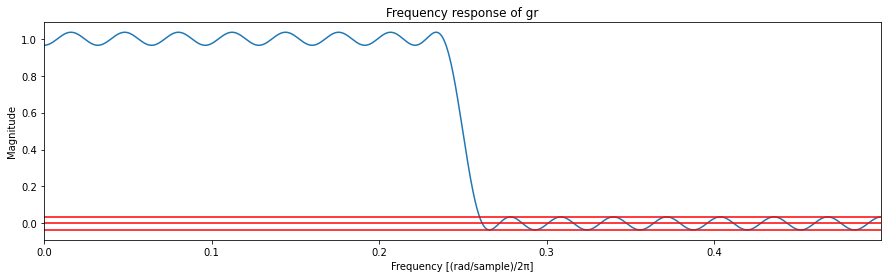

In [92]:
# Obtains the δ of the Chebyshev’s alternance property of the filter gr
start_stopband = np.where(freq > 0.30)[0][0]
end_stopband = np.where(freq > 0.6)[0][0]
δgr = max(np.abs(np.real(gr.mag)[start_stopband:end_stopband]))

# Shows the δgr obtained in the
print("The obtained δgr was {δgr}, which can be clearly seen highlighted in the plot below.\n")
gr.freqz_plot(db=False, absolute=False, yhighlights=[-δgr, 0, δgr])

# Obtains the filter g+
g_plus = g.tdata + (2*δgr)*np.array((N-1)*[0] + [1] + (N-1)*[0])
g_plus = Filter("g_plus", tdata=g_plus)

# 1.6

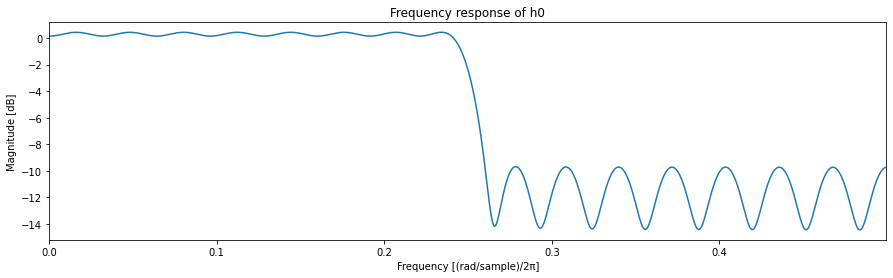

In [93]:
# Defines the tolerance of the fixed point method
ε = 1E-3

# Determines the first values to be used by the method
h0 = np.array([1] + (N-1)*[0])
first_column = np.array((N-1)*[0] + [h0[0]])
A = hankel(first_column, h0)
g_plus_N = g_plus.tdata[0:N]

# Calculates the first error
error = norm(A.dot(h0) - g_plus_N)

# Iterates until obtain an acceptable result
while error > ε:
    h0 = inv(A).dot(g_plus_N)                      # First, calculate h0
    h0 *= np.sqrt(g_plus_N[N-1])/norm(h0)          # Normalizing h0
    first_column = np.array((N-1)*[0] + [h0[0]])   # Reobtaining the matrices for the system
    A = hankel(first_column, h0)
    error = norm(A.dot(h0) - g_plus_N)             # Calculating the error

# Final filter after solving the system
h0 = Filter("h0", tdata=h0)

# Verifying its frequency response
h0.freqz_plot()


# 1.7

We can define $h_0$, $h_1$, $f_0$ and $f_1$ as the following

$h_0(n)$ as defined above

$h_1(n)$ is defined as $-(-1)^n*h_0(N-1-n)$

The 'f' is obtained by reversing time and conjugating the samples.

$f_0$ is defined as ${h_0(N-1-n)}$

And finally,

$f_1$ is defined as  $-(-1)^n*h_0(n)$ = $-h_1(N-1-n)$

In [94]:
sign = [(-1)**i for i in range(N)]

h1 = sign*np.flip(h0.tdata)
h1 = Filter("h1", tdata=h1)

f0 = np.flip(h0.tdata)
f0 = Filter("f0", tdata=f0)

f1 = -1*(np.flip(h1.tdata))
f1 = Filter("f1", tdata=f1)

# 1.8

In [99]:
# Obtains the audio signal from its file
audio = Signal("audio", file="./inputs/homme3.wav")

# Upper part of CQF
upper_h0 = h0.apply("upper_h0", audio)
upper_f0 = f0.apply("upper_f0", upper_h0)

# Lower part of CQF
lower_h1 = h1.apply("lower_h1", audio)
lower_f1 = f1.apply("lower_f1", lower_h1)

# Reconstructs the original sound by adding both components
reconstructed = Signal("reconstructed", upper_f0.tdata + lower_f1.tdata, fs=audio.fs)

# Listens to the sound
reconstructed.listen()


In the picture shown below its clear that the signal was perfectly reconstructed.


[]

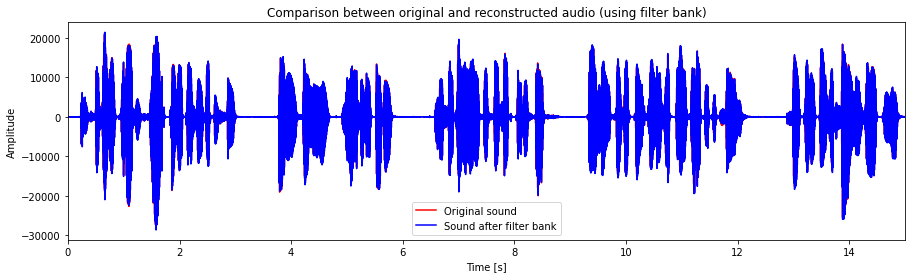

In [105]:
# Obtains the time of both signals
taudio = np.linspace(0, len(audio.tdata)/audio.fs, len(audio.tdata))
treconstructed = np.linspace(0, len(reconstructed.tdata)/reconstructed.fs, len(reconstructed.tdata))

# Visually compare the reconstructed and the original sound
print("\nIn the picture shown below its clear that the signal was perfectly reconstructed.")
plt.figure(figsize=(15, 4))
plt.title("Comparison between original and reconstructed audio (using filter bank)")
plt.plot(t, audio.tdata, color="r")
plt.plot(treconstructed, reconstructed.tdata, color="b")
plt.xlim(t[0], t[-1])
plt.legend(("Original sound", "Sound after filter bank"))
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot()

# 2.1

In [ ]:
# Obtains the input signal x1 and x2 
# Obtains the input signal x1 and x2 
x1 = Signal(name="x1", file="./inputs/femme3.wav")
x2 = Signal(name="x2", file="./inputs/homme3.wav")

# Defines the over and under sampling constants
L = 2
M = 2

# Runs the system
w1 = x1.over_sample("w1", L)            # Obtains the over sampled signal w using L=2 (Fw=48*2=96kHz)
w2 = x2.over_sample("w2", L)


# Upper part of CQF
upper_f0 = f0.apply("upper_f0",w1)

# Lower part of CQF
lower_f1 = f1.apply("lower_f1",w2)

# Now, reconstructing the sound adding both components
mix = Signal("mix",upper_f0.data + lower_f1.data,freq=w1.freq)

# Listening the sound
mix.listen()
plt.plot(mix.data)


# 2.2

In [ ]:
#Decoding the mixed signal

upper_h0 = h0.apply("upper_h0",mix)
lower_h1 = h1.apply("lower_h1",mix)

y1 = upper_h0.under_sample("y1", M)           # Undersample v to obtain the output of the system using M=3 (Fy=96/3=32kHz)
y2 = lower_h1.under_sample("y2", M) 


# Visually comparing both sounds
plt.plot(x1.data, color="r")
plt.plot(y1.data, color="b")
plt.legend(("Original sound femme", "Sound after transmultiplexer"))
plt.plot()

# Visually comparing both sounds
plt.plot(x2.data, color="r")
plt.plot(y2.data, color="b")
plt.legend(("Original sound homme", "Sound after transmultiplexer"))
plt.plot()

# 2.3

# 2.4